1.Data Exploration

Matplotlib is building the font cache; this may take a moment.


Sample rows:


,student_id,name,class,comprehension,attention,focus,retention,engagement_time,assessment_score
0,S1000,Yesenia Browning,12th,85,83,60,54,9,66
1,S1001,Rodney Lara,8th,91,49,32,98,6,72
2,S1002,Raymond Cooper,10th,92,48,37,50,16,67
3,S1003,Nancy Rivera,10th,63,95,53,85,17,79
4,S1004,John Villegas,12th,54,59,44,71,2,48


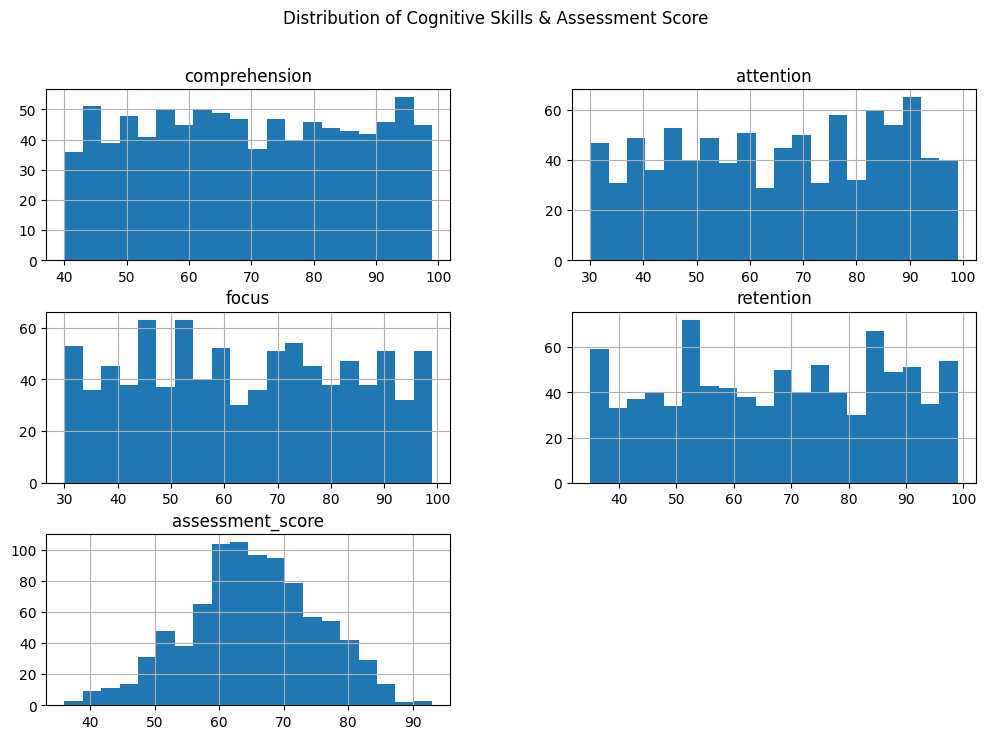


Missing values per column:
student_id          0
name                0
class               0
comprehension       0
attention           0
focus               0
retention           0
engagement_time     0
assessment_score    0
dtype: int64


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv(r"C:\Users\anshu\Downloads\student_dataset_900.csv")

# Show sample rows
print("Sample rows:")
display(df.head())

# Check distributions of all scores
score_cols = ["comprehension", "attention", "focus", "retention", "assessment_score"]
df[score_cols].hist(bins=20, figsize=(12, 8))
plt.suptitle("Distribution of Cognitive Skills & Assessment Score")
plt.show()

# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())


 2.Correlation Analysis


Correlation with assessment_score:
assessment_score    1.000000
retention           0.451899
comprehension       0.427776
focus               0.379163
attention           0.351616
engagement_time     0.241335
Name: assessment_score, dtype: float64


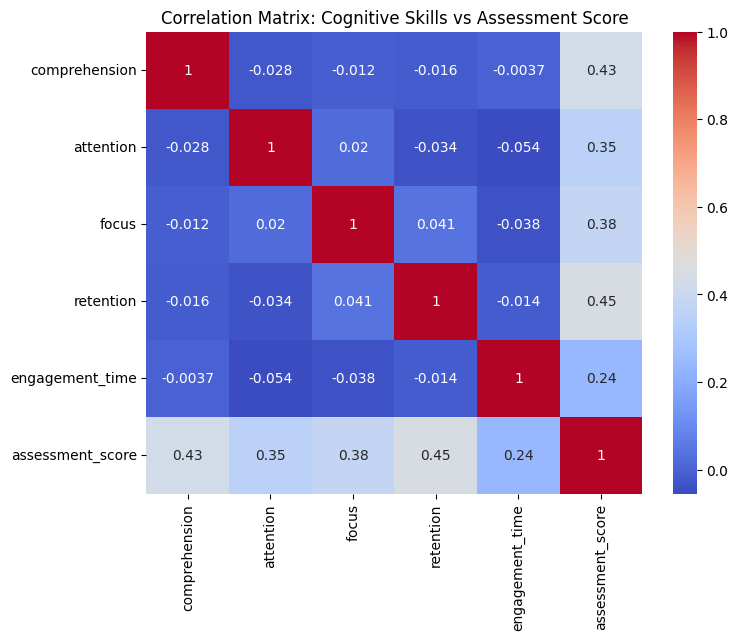

In [4]:
# Compute correlation matrix for relevant columns
corr = df[["comprehension", "attention", "focus", "retention", "engagement_time", "assessment_score"]].corr()

print("\nCorrelation with assessment_score:")
print(corr["assessment_score"].sort_values(ascending=False))

# Correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix: Cognitive Skills vs Assessment Score")
plt.show()


ML Model with XGBoost

In [5]:


import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

# Load dataset
df = pd.read_csv(r"C:\Users\anshu\Downloads\student_dataset_900.csv")

# Feature engineering
df['mean_cognitive'] = (df['comprehension'] + df['attention'] + df['focus'] + df['retention']) / 4
df['attention_focus'] = df['attention'] * df['focus']
df['comprehension_retention'] = df['comprehension'] * df['retention']

features = [
    'comprehension', 'attention', 'focus', 'retention',
    'engagement_time', 'mean_cognitive', 'attention_focus', 'comprehension_retention'
]
X = df[features]
y = df['assessment_score']

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# XGBoost hyperparameter search space
param_dist = {
    'n_estimators': [300, 500, 750, 1000],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.2, 0.5, 1],
    'reg_lambda': [0.5, 1, 2, 5]
}

xgb = XGBRegressor(random_state=42)
rsearch = RandomizedSearchCV(xgb, param_distributions=param_dist, 
                            n_iter=30, scoring='r2',
                            n_jobs=-1, cv=5, random_state=42, verbose=1)
rsearch.fit(X_train, y_train)

best_xgb = rsearch.best_estimator_
best_xgb.fit(X_train, y_train)
y_pred = best_xgb.predict(X_test)

# Metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# 5-fold cross-validation for robust estimate
cv = KFold(n_splits=5, shuffle=True, random_state=42)
r2_cv_scores = cross_val_score(best_xgb, X_scaled, y, cv=cv, scoring='r2')

print(f"Best Hyperparameters: {rsearch.best_params_}")
print("Test R² Score:", r2)
print("Test MAE:", mae)
print("Test MSE:", mse)
print("Test RMSE:", rmse)
print(f"Cross-validated R²: {r2_cv_scores.mean():.4f} ± {r2_cv_scores.std():.4f}")

# Feature importance
importances = best_xgb.feature_importances_
feature_importance_df = pd.DataFrame({'feature': features, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)
print(feature_importance_df)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Hyperparameters: {'subsample': 0.9, 'reg_lambda': 0.5, 'reg_alpha': 0, 'n_estimators': 750, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.9}
Test R² Score: 0.725355863571167
Test MAE: 4.119008541107178
Test MSE: 26.35812759399414
Test RMSE: 5.134016711503201
Cross-validated R²: 0.7201 ± 0.0402
                   feature  importance
5           mean_cognitive    0.563958
7  comprehension_retention    0.159966
4          engagement_time    0.093523
6          attention_focus    0.084916
0            comprehension    0.027408
3                retention    0.024665
2                    focus    0.023390
1                attention    0.022174


Clustering Students into Learning Personas

In [6]:
from sklearn.cluster import KMeans

clust_feats = ["comprehension", "attention", "focus", "retention"]
X_clust = df[clust_feats]

# Standardize features
scaler = StandardScaler()
X_clust_scaled = scaler.fit_transform(X_clust)

# KMeans clustering (4 personas)
kmeans = KMeans(n_clusters=4, random_state=42)
df['persona'] = kmeans.fit_predict(X_clust_scaled)

# View centroid profiles (standardized scale)
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=clust_feats)
print("Persona centroids:")
display(centroids)

# Count students per persona
print("\nStudents per persona cluster:")
print(df['persona'].value_counts())

# Sample students from each cluster (for labeling)
for i in range(4):
    print(f"\nSample students in persona cluster {i}:")
    display(df[df['persona'] == i].head(3))


Persona centroids:


,comprehension,attention,focus,retention
0,-0.378299,0.174578,-0.775028,-0.917134
1,0.515875,-0.349649,-0.760381,0.889423
2,-0.920494,0.114289,0.733424,0.536298
3,0.851900,0.027121,0.810284,-0.398025



Students per persona cluster:
persona
0    240
2    226
3    223
1    211
Name: count, dtype: int64

Sample students in persona cluster 0:


,student_id,name,class,comprehension,attention,focus,retention,engagement_time,assessment_score,mean_cognitive,attention_focus,comprehension_retention,persona
2,S1002,Raymond Cooper,10th,92,48,37,50,16,67,56.75,1776,4600,0
4,S1004,John Villegas,12th,54,59,44,71,2,48,57.00,2596,3834,0
7,S1007,Edward Campos,12th,43,51,74,43,4,39,52.75,3774,1849,0



Sample students in persona cluster 1:


,student_id,name,class,comprehension,attention,focus,retention,engagement_time,assessment_score,mean_cognitive,attention_focus,comprehension_retention,persona
1,S1001,Rodney Lara,8th,91,49,32,98,6,72,67.50,1568,8918,1
6,S1006,Tamara Smith,8th,69,63,60,91,6,77,70.75,3780,6279,1
9,S1009,Jennifer Payne,9th,98,35,37,56,14,65,56.50,1295,5488,1



Sample students in persona cluster 2:


,student_id,name,class,comprehension,attention,focus,retention,engagement_time,assessment_score,mean_cognitive,attention_focus,comprehension_retention,persona
3,S1003,Nancy Rivera,10th,63,95,53,85,17,79,74.00,5035,5355,2
5,S1005,Matthew Rosario,11th,61,82,72,76,17,75,72.75,5904,4636,2
8,S1008,Frank Harper,9th,52,96,95,98,16,82,85.25,9120,5096,2



Sample students in persona cluster 3:


,student_id,name,class,comprehension,attention,focus,retention,engagement_time,assessment_score,mean_cognitive,attention_focus,comprehension_retention,persona
0,S1000,Yesenia Browning,12th,85,83,60,54,9,66,70.50,4980,4590,3
14,S1014,Eddie White,8th,94,88,68,52,7,73,75.50,5984,4888,3
17,S1017,Stephanie Osborne,9th,73,58,74,38,9,69,60.75,4292,2774,3


In [2]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import json  # for export

# -----------------------------
# Load dataset
# -----------------------------
df = pd.read_csv(r"C:\Users\anshu\Downloads\student_dataset_900.csv")

# -----------------------------
# Feature Engineering
# -----------------------------
df['mean_cognitive'] = (df['comprehension'] + df['attention'] + df['focus'] + df['retention']) / 4
df['attention_focus'] = df['attention'] * df['focus']
df['comprehension_retention'] = df['comprehension'] * df['retention']

# -----------------------------
# Clustering (3 types of learners)
# -----------------------------
clust_feats = ['comprehension', 'attention', 'focus', 'retention']
scaler = StandardScaler()
X_clust_scaled = scaler.fit_transform(df[clust_feats])

kmeans = KMeans(n_clusters=3, random_state=42)
df['persona'] = kmeans.fit_predict(X_clust_scaled)

# -----------------------------
# Model Training
# -----------------------------
features = [
    'comprehension', 'attention', 'focus', 'retention',
    'engagement_time', 'mean_cognitive', 'attention_focus', 'comprehension_retention'
]
X = df[features]
y = df['assessment_score']

# Feature scaling
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# XGBoost hyperparameter search space
param_dist = {
    'n_estimators': [300, 500, 750, 1000],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.2, 0.5, 1],
    'reg_lambda': [0.5, 1, 2, 5]
}

xgb = XGBRegressor(random_state=42)
rsearch = RandomizedSearchCV(
    xgb,
    param_distributions=param_dist,
    n_iter=30,
    scoring='r2',
    n_jobs=-1,
    cv=5,
    random_state=42,
    verbose=1
)
rsearch.fit(X_train, y_train)

best_xgb = rsearch.best_estimator_
best_xgb.fit(X_train, y_train)
y_pred = best_xgb.predict(X_test)

# -----------------------------
# Metrics
# -----------------------------
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# 5-fold cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)
r2_cv_scores = cross_val_score(best_xgb, X_scaled, y, cv=cv, scoring='r2')

print(f"Best Hyperparameters: {rsearch.best_params_}")
print("Test R² Score:", r2)
print("Test MAE:", mae)
print("Test MSE:", mse)
print("Test RMSE:", rmse)
print(f"Cross-validated R²: {r2_cv_scores.mean():.4f} ± {r2_cv_scores.std():.4f}")

# -----------------------------
# Feature Importance + Predictions
# -----------------------------
df['predicted_score'] = best_xgb.predict(X_scaled)
importances = best_xgb.feature_importances_

# Convert to normal floats for JSON
feature_importance = {feature: float(imp) for feature, imp in zip(features, importances)}

# -----------------------------
# Export to JSON
# -----------------------------
# Save student records (including predicted_score and persona)
df.to_json('students.json', orient='records')

# Save feature importance safely
with open('feature_importance.json', 'w') as f:
    json.dump(feature_importance, f, indent=4)

print("✅ JSON files created: students.json & feature_importance.json")


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Hyperparameters: {'subsample': 0.9, 'reg_lambda': 0.5, 'reg_alpha': 0, 'n_estimators': 750, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.9}
Test R² Score: 0.725355863571167
Test MAE: 4.119008541107178
Test MSE: 26.35812759399414
Test RMSE: 5.134016711503201
Cross-validated R²: 0.7201 ± 0.0402
✅ JSON files created: students.json & feature_importance.json
